Processing Kevin.csv data
Creating RawArray with float64 data, n_channels=8, n_times=11577
    Range : 0 ... 11576 =      0.000 ...    46.304 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


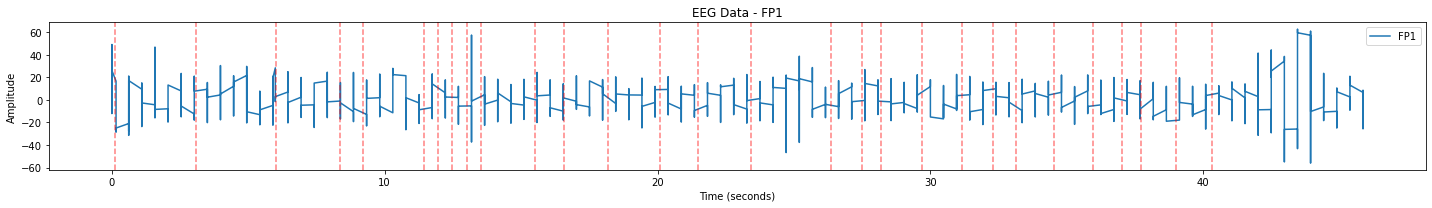

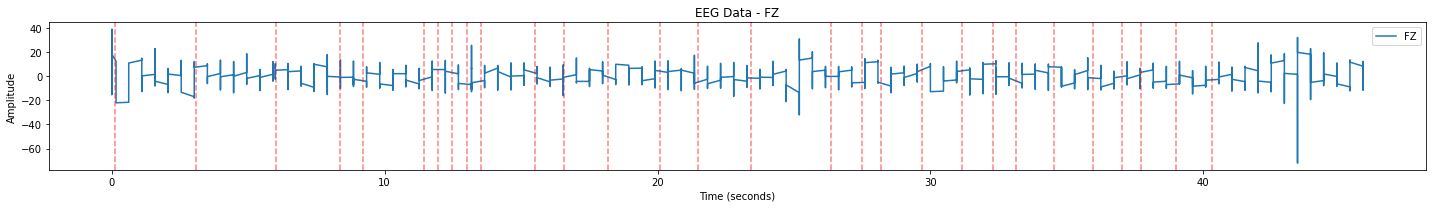

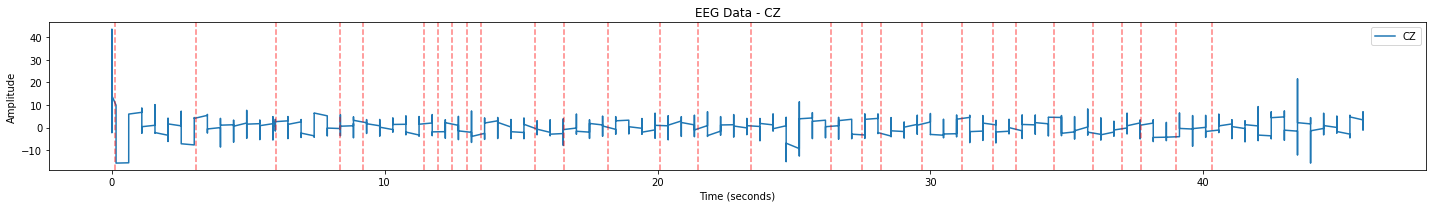

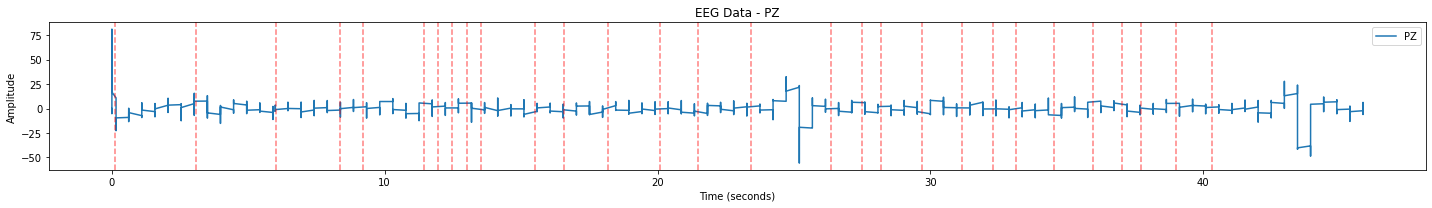

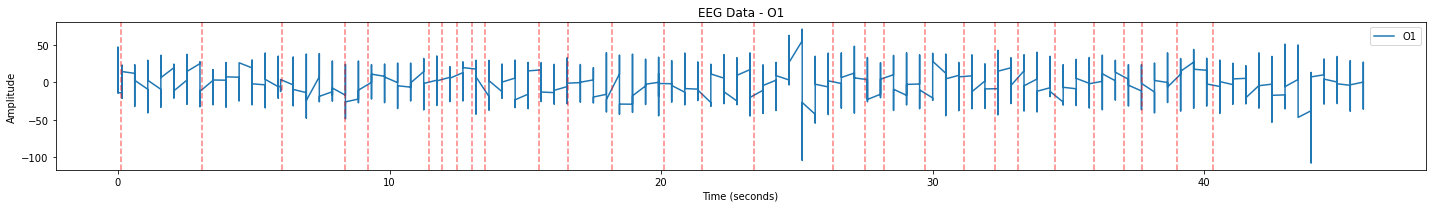

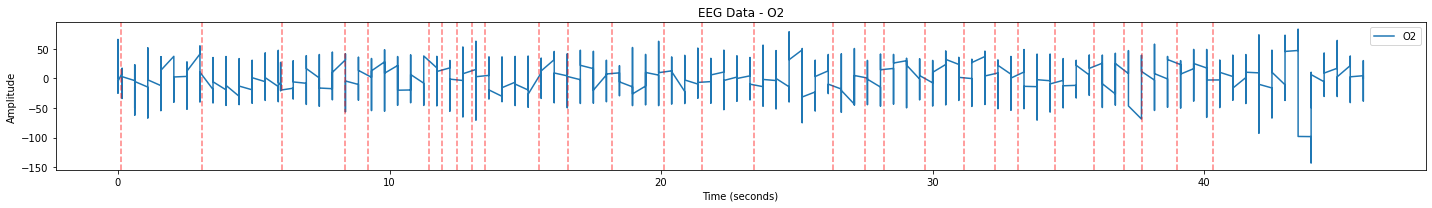

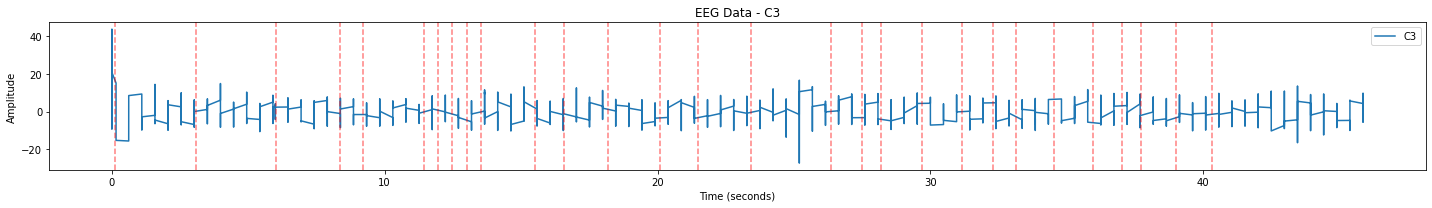

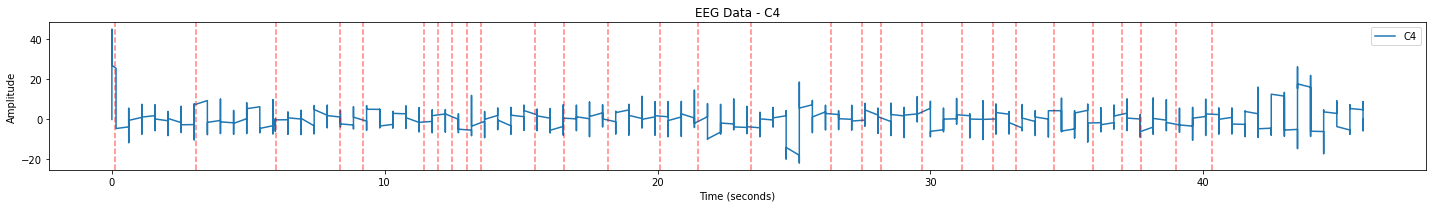

Processing Benson.csv data
Creating RawArray with float64 data, n_channels=8, n_times=17006
    Range : 0 ... 17005 =      0.000 ...    68.020 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


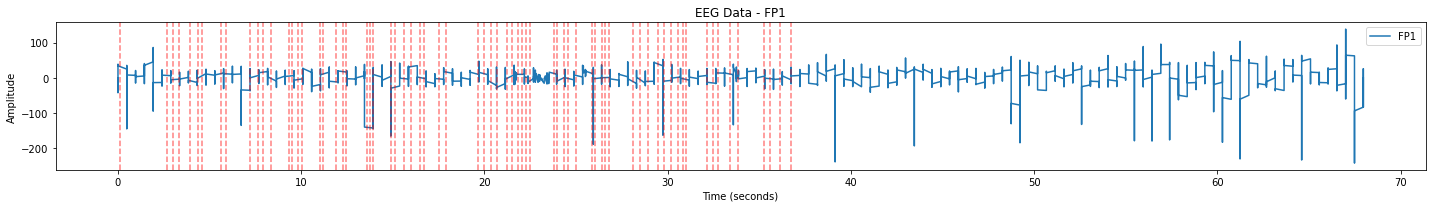

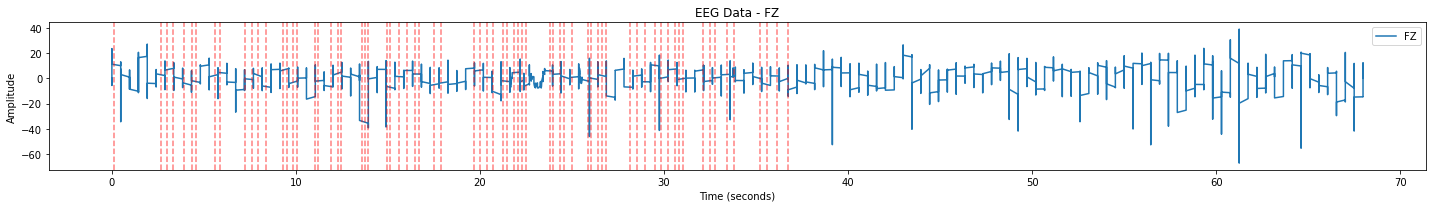

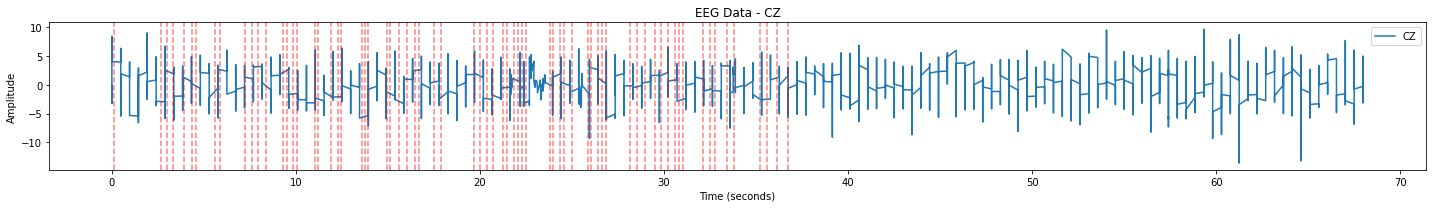

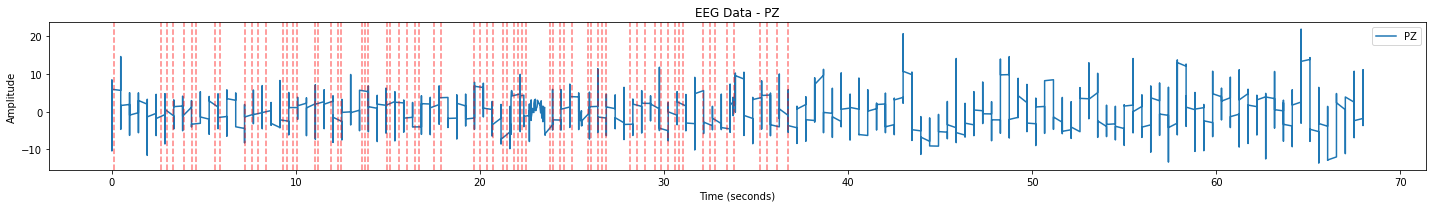

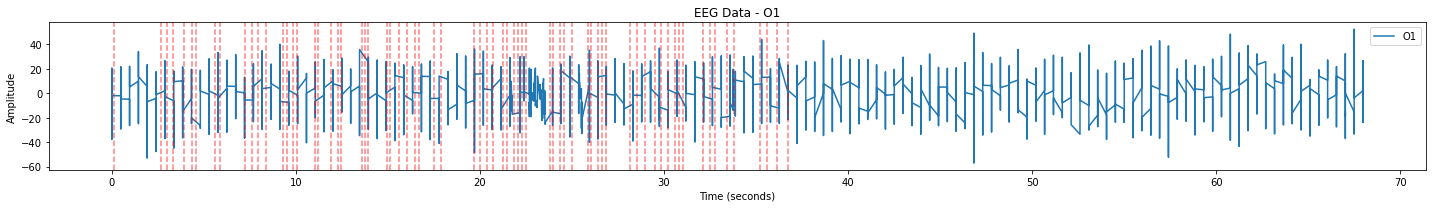

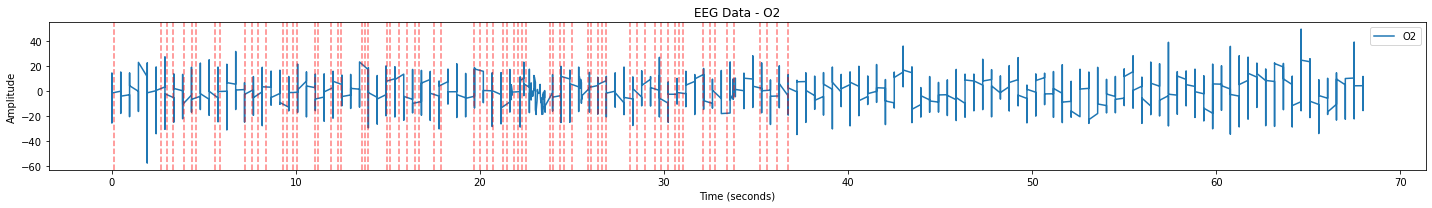

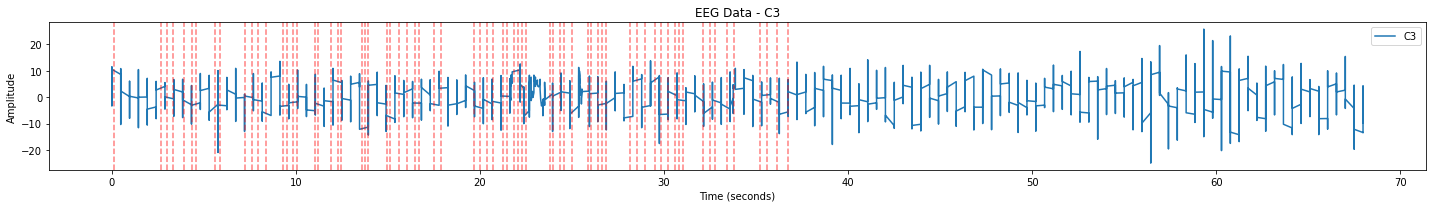

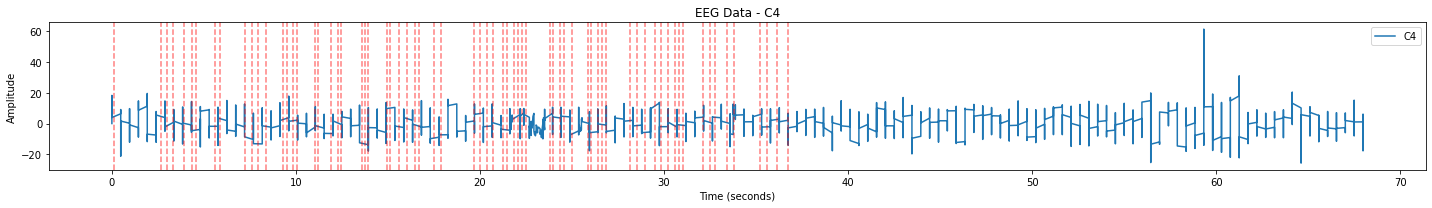

In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import mne
import re
import numpy as np

def process_macro_file(filename):
    # Read in the macro file
    with open(filename) as f:
        lines = f.readlines()

    # Extract all the delays from the file
    result = []
    for line in lines:
        if "<Delay>" in line:
            result.append(int(re.sub('\D', '', line)))

    # Insert 0 at the beginning
    result.insert(0, 0)
    # Convert to float, and round to 4 decimal places
    result = [float(i) * 0.001 for i in result]
    result = [round(i, 4) if isinstance(i, float) else i for i in result]

    # Sum every two delays together as a single mouse click
    sum_list = []
    for i in range(0, len(result) - 1, 2):
        if isinstance(result[i], float) and isinstance(result[i + 1], float):
            sum_list.append(result[i] + result[i + 1])
    for i in range(1, len(sum_list)):
        sum_list[i] += sum_list[i - 1]
    sum_list = [round(i, 4) if isinstance(i, float) else i for i in sum_list]

    return sum_list

def process_eeg_data(filename, macro_file, start_index=500):
    # Read the CSV file
    eeg_data = pd.read_csv(filename, delimiter='\t', header=None)

    # Remove data before the start index
    eeg_data = eeg_data.iloc[start_index:]

    # Process macro mouse record file
    sum_list = process_macro_file(macro_file)

    # Extract the timestamp column
    timestamps = eeg_data.iloc[:, 22]

    # Subtract the first value from the entire column
    adjusted_timestamps = timestamps - timestamps.iloc[0]

    # Replace the 23rd column with the adjusted_timestamps
    eeg_data[22] = adjusted_timestamps

    # Select the desired columns (2-9)
    selected_columns = eeg_data.iloc[:, [i for i in range(1, 9)]]

    # Channel names
    channel_names = ['FP1', 'FZ', 'CZ', 'PZ', 'O1', 'O2', 'C3', 'C4']
    n_channels = len(channel_names)

    # Create an MNE Info object
    info = mne.create_info(ch_names=channel_names, sfreq=250, ch_types='eeg')

    # Convert the data to an MNE Raw object
    raw_data = mne.io.RawArray(selected_columns.T, info)

    # Apply a bandpass filter (for example, 1-50 Hz)
    raw_data.filter(l_freq=1, h_freq=50)

    plt.rcParams["figure.autolayout"] = True
    # Plot each channel individually
    for i, ch_name in enumerate(channel_names):
        plt.figure(figsize=(20, 3))
        plt.plot(adjusted_timestamps, raw_data.get_data(picks=ch_name).T, label=ch_name)

        # Plot vertical lines for mouse clicks
        for click_time in sum_list:
            plt.axvline(x=click_time, color='red', linestyle='--', alpha=0.5)

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude')
        plt.title(f'EEG Data - {ch_name}')
        plt.legend()
        plt.show()


# Process 'Kevin.csv' data
print("Processing Kevin.csv data")
process_eeg_data('Kevin.csv', 'kevin_macro.txt', start_index=500)

# Process 'Benson.csv' data
print("Processing Benson.csv data")
process_eeg_data('Benson.csv', 'benson_macro.txt', start_index=500)
